In [316]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [317]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [1719]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV

In [319]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [320]:
import requests
import json
import datetime
import time

In [321]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [322]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [2032]:
# Import Sales Data
bar_sales_file = 'bar_x_sales_export.csv'
rest_1_file = 'rest_1_dinner_sales.csv'

In [2033]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-01' # End Date Exclusive

In [2034]:
search_business = 'Jupiter Disco'
location = 'Brooklyn, NY'

## Import / Clean / Prep File

In [2035]:
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    return df

df = import_parse(rest_1_dinner);

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


In [2036]:
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]
    
df = filter_df(df, start_date, end_date)

In [2037]:
def daily_average_matrix_ann(df):
    
    matrix = df.groupby([df.index.dayofweek, df.index.month, df.index.year]).agg({'sales': 'mean'})
    matrix = matrix.rename_axis(['day', 'month', 'year'])
    return matrix.unstack(level=1)

daily_average_matrix_ann(df)

sales                                                  \
month             1           2           3           4           5    
day year                                                               
0   2017  13114.5580  13057.4550  13456.6600  15420.8150  15619.4040   
    2018  10098.7840  15325.0900  12548.1350  14636.8100  18291.7050   
    2019  14084.3925  13828.3650  13939.3850  13946.5600  16315.4975   
1   2017  13402.5860  14033.1175  10172.2475  14505.2125  16682.6960   
    2018  12947.5700  13145.9425  12696.3975  12921.6200  16359.0000   
    2019  10744.8180  14092.9600  13846.2950  16179.8380  16528.1000   
2   2017  13454.2550  13987.3500  13533.9540  14666.2425  16861.9320   
    2018  13389.5180  13188.9900  13296.6500  15260.8800  17667.2340   
    2019  13250.4560  18342.9500  14176.3775  16343.3250  15137.7940   
3   2017  14265.4375  14967.1450  13729.5960  15276.0850  16670.6650   
    2018  13364.3000  15426.3475  14020.2340  15511.2350  17473.5760   
    2019  14354.0560  14821.2075  14426.3725  15997.7475  16693.7960   
4   2017  15365.2000  16154.2575  15387.7400  18623.9575  19017.4725   
    2018  15648.6725  15652.0100  15554.3760  17807.9300  22055.2500   
    2019  16552.3275  16212.2225  15922.3040  16607.2825  21530.8840   
5   2017  17373.3325  16653.0825  17840.6575  19667.3140  20002.4700   
    2018  16401.7675  17866.3850  17624.0680  20923.9000  17995.3650   
    2019  22623.3650  18411.1550  18492.5980  21543.9300  24327.2450   
6   2017  13335.4300  10632.7400  14822.8375  15458.3660  18028.2375   
    2018  14212.3750  11812.9200  14151.9750  16077.8440  17126.2775   
    2019  14322.2850  11145.8400  14410.9540  16448.1125  16313.3400   

                                                                      \
month             6           7           8           9           10   
day year                                                               
0   2017  15633.5500  17677.0800  16662.3000  16909.1325  14552.7500   
    2018  17216.8575  17534.5060  16256.8325  15988.9975  21241.6460   
    2019         NaN         NaN         NaN         NaN         NaN   
1   2017  16493.9275  17217.5900  14951.4600  15740.6050  15490.4700   
    2018  17901.2600  17031.8700  15350.9375  15872.9700  14856.9520   
    2019         NaN         NaN         NaN         NaN         NaN   
2   2017  19167.8950  16988.6350  18485.1660  17022.6025  16328.0075   
    2018  16877.9250  16634.2000  17567.9500  15378.0450  17951.2500   
    2019         NaN         NaN         NaN         NaN         NaN   
3   2017  18556.5380  16449.4375  19084.5960  17664.6325  18379.7050   
    2018  18458.6225  18586.1150  18142.5180  17496.7250  12317.4350   
    2019         NaN         NaN         NaN         NaN         NaN   
4   2017  20566.6220  18752.2725  20013.3825  22247.2960  20541.6400   
    2018  20221.2660  16952.3425  19176.4480  19581.7550  17417.3800   
    2019         NaN         NaN         NaN         NaN         NaN   
5   2017  22854.0900  21847.6520  21851.1525  21502.4160  22722.6350   
    2018  20513.3560  21149.9750  18947.4775  19692.8500  19130.2825   
    2019         NaN         NaN         NaN         NaN         NaN   
6   2017  17394.1575  20702.2360  19243.2350  20489.9300  18160.3160   
    2018  17023.7800  17943.3780  17080.4275  16844.8920  16786.3175   
    2019         NaN         NaN         NaN         NaN         NaN   

                                  
month             11          12  
day year                          
0   2017  13434.9525  10682.9575  
    2018  13030.6625  11405.9500  
    2019         NaN         NaN  
1   2017  14671.3850  14065.7975  
    2018  13332.8125  12669.2100  
    2019         NaN         NaN  
2   2017  14458.0520  14516.3950  
    2018  15508.1100  13369.2325  
    2019         NaN         NaN  
3   2017  12801.6120  15899.8825  
    2018  11564.6680  17304.0925  
    2019         NaN         NaN  
4   2017  16945.6025  16113.0820

## Pull Weather Data

### Latitude + Longitude from Yelp API

In [1572]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Coordinates found for {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)
#print(f'Latitude: {lat}\nLongitude: {long}')

Coordinates found for Jupiter Disco


### Darksky API Call

In [330]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [331]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    return r.json()

In [332]:
# Parse Data from API Call into Dictionaries
def parse_data(data):

    time = datetime.datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        entry = {'date': time,
                 'temperature': data['currently']['temperature'],
                 'apparent_temperature': data['currently']['apparentTemperature'],
                 'precip_prob': data['currently']['precipProbability'],
                 'summary': data['currently']['icon'],
                 'moonphase': data['daily']['data'][0]['moonPhase']}
    
    except KeyError:
        
        entry = {'date': time,
                 'temperature': 'NaN',
                 'apparent_temperature': 'NaN',
                 'precip_prob': 'NaN',
                 'summary': 'NaN',
                 'moonphase': 'NaN'}
    
    return entry

In [351]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
        
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long);

In [446]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df.set_index('date', inplace=True)
    
    # Columns to cast as floats & fill NaN values with Previous day:
    cols_to_float = ['temperature', 'apparent_temperature', 'precip_prob', 'moonphase']
    
    # Cast required columns as floats
    df[cols_to_float] = df[cols_to_float].astype(float)
    
    # Fill Temperature NaN with previous day
    for col in cols_to_float:
        
        df[col].fillna(method='ffill',inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [447]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

### START HERE

In [2467]:
current_file = rest_1_file

df = filter_df(import_parse(current_file), start_date, end_date)

weather_csv_file = 'weather_2017-01-01_to_2019-06-01.csv'

weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
weather_df_csv['summary'].fillna(value='none', inplace=True)

"rest_1_dinner_sales.csv" has been imported + parsed. The file has 889 rows.


In [2468]:
# MERGE SALES DATAFRAME WITH WEATHER DATAFRAME
def join_sales_weather(sales_df, weather_df):
    
    df = pd.merge(sales_df, weather_df, how='left', on='date')
    
    return df

df = join_sales_weather(df, weather_df_csv)

dfx = df.copy(deep=True)

### Closures

In [2469]:
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-02-04', '2019-02-03']
closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]

drop_closed = False

def drop_closed_days(df):

    if drop_closed:
        
        df = df.loc[df['sales'] > 0]
        
    else:

        # CLOSED FEATURE
        cal = calendar()

        # Local list of days with zero sales
        potential_closed_dates = df[df['sales'] == 0].index

        # Enocodes closed days with 1
        df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                                  (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    return df

dfx = drop_closed_days(dfx)

### Drop Outliers

In [2470]:
# Drop Outliers 

# Number to Drop for each Day Of Week
max_vals = 2
min_vals = 2

def drop_outliers(df):
    
    print('Starting Observations: ', len(df), '\n')
    
    for d in df['day_of_week'].unique():
        
        # Create List of Rows to Drop
        ## $0 Sales are Not Dropped because typically indicative of Business being Closed
        high_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nlargest(max_vals).index)
        low_sales = list(df[(df['day_of_week'] == d) & (df['sales'] > 0)]['sales'].nsmallest(min_vals).index)
        
        # Filter Out High / Low Sales
        df = df[~df.index.isin(high_sales)]
        df = df[~df.index.isin(low_sales)]
        
    df['sales'] = np.where(df['sales'] < 0, 0, df['sales'])
    
    print('Ending Observations: ', len(df), '\n')
    
    return df

dfx = drop_outliers(dfx)


Starting Observations:  880 

Ending Observations:  852 



In [2471]:
dfx.describe()

,sales,apparent_temperature,moonphase,precip_prob,temperature,day_of_week,month,closed
count,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000,852.000000
mean,16218.213721,53.789249,0.495939,0.082089,54.746549,2.994131,5.904930,0.012911
std,3343.275599,19.956601,0.286767,0.237794,17.709949,1.999698,3.431947,0.112956
min,0.000000,-5.540000,0.000000,0.000000,8.700000,0.000000,1.000000,0.000000
25%,14128.517500,38.457500,0.250000,0.000000,40.170000,1.000000,3.000000,0.000000
50%,15853.425000,54.035000,0.490000,0.000000,54.035000,3.000000,5.000000,0.000000
75%,18440.207500,71.657500,0.740000,0.000000,71.165000,5.000000,9.000000,0.000000
max,25070.040000,95.170000,0.990000,1.000000,88.980000,6.000000,12.000000,1.000000


### Create Day & Month Clusters

In [2472]:
from sklearn.cluster import KMeans

day_k = 3
mo_k = 3

def create_clusters(df, col, k):
    
    # MAKE DATAFRAME FROM DESCRIBE() METHOD, USE CENTRAL TENDENCIES AS FEATURES
    daily_summary = df.groupby(col)['sales'].aggregate(['mean', 'median', 'std', 'min', 'max'])
    df = daily_summary.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

day_dict = create_clusters(dfx, 'day_of_week', day_k)
month_dict = create_clusters(dfx, 'month', mo_k)

In [2473]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x])
    df['mo_cluster'] = df['month'].apply(lambda x: month_dict[x])
    
    return df

dfx = add_clusters(dfx)

In [2474]:
# Print Clusters
print('Day Clusters: ', day_dict, '\n', 'Total Clusters: ', len(set(day_dict.values())), '\n')
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Day Clusters:  {0: 2, 1: 2, 2: 2, 3: 2, 4: 1, 5: 1, 6: 0} 
 Total Clusters:  3 

Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1} 
 Total Clusters:  3


### Feature Engineering

In [2475]:
# Check for Holiday & $0 in Sales
# Pass Other Closed Dates here
temp_delta_window = 7

def add_features(df):
    
    cal = calendar()
    
    # POOR WEATHER FEATURE
    poor_weather_list = ['rain', 'snow', 'sleet']
    df['summary'] = df['summary'].apply(lambda x: x.split('-'))
    df['poor_weather'] = np.where(df['summary'].apply(lambda x: np.any(np.in1d(x, poor_weather_list))), 1, 0)
    df = df.drop(['summary'], axis=1)
    
    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    monday_three_days = [date for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['monday_three_day'] = np.where(df.index.isin(monday_three_days), 1, 0)
    
    # ROLLING AVERAGE TEMP & DELTA
    #df['temperature_delta'] = df['apparent_temperature'] - df['apparent_temperature'].rolling(temp_delta_window).mean()
    #df['temperature_delta'] = df['temperature_delta'].fillna(value=0)
    
    return df

dfx = add_features(dfx)

In [2476]:
def add_dummies(df):
    
    daily_dummies = pd.get_dummies(df['day_cluster'], prefix='dayclus')
    monthly_dummies = pd.get_dummies(df['mo_cluster'], prefix='moclus')
    
    df = pd.concat([df, daily_dummies, monthly_dummies], axis=1)
    df = df.drop(['day_of_week', 'day_cluster', 'month', 'mo_cluster'], axis=1)
    
    return df

dfx = add_dummies(dfx)

In [2477]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        for d in [col for col in df.columns if col.startswith('dayclus_')]:
            
            #col_name = d + '_X_' + 'poor_weather'
            
            #df[col_name] = df[d] * df['poor_weather']
            
            for m in [col for col in df.columns if col.startswith('moclus_')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('moclus_')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

dfx = add_interactions(dfx)

In [2478]:
# Feature Selection / Drop unnecessary or correlated columns
cols_to_drop = ['temperature', 'moonphase']

def feature_selection(df):
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

dfx = feature_selection(dfx)

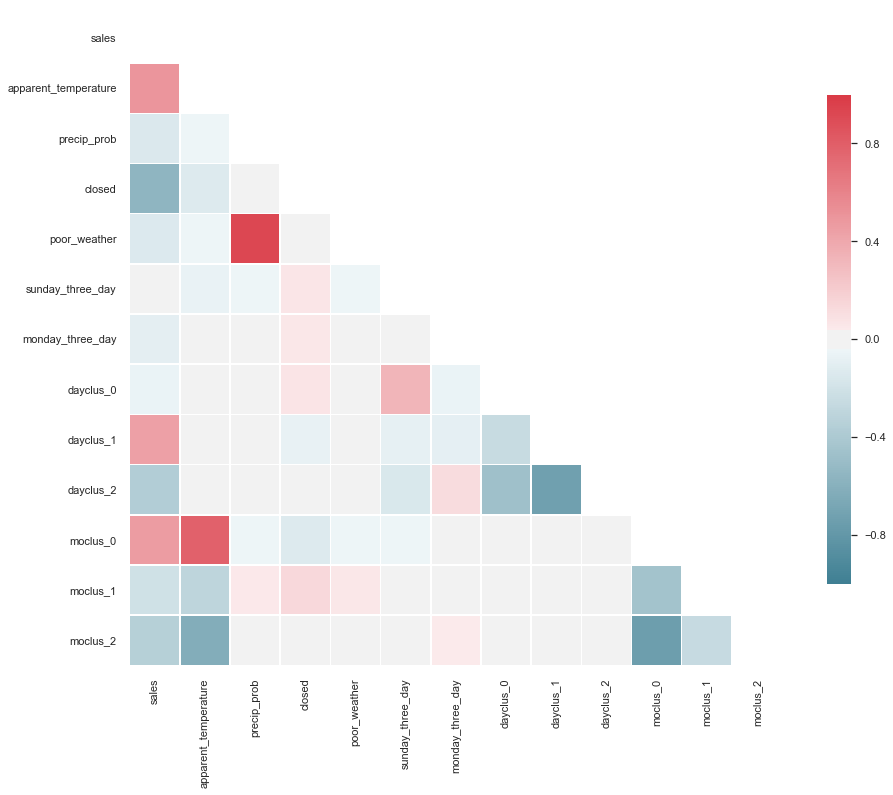

In [2479]:
def corr_chart(df):
    
    corr = dfx.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

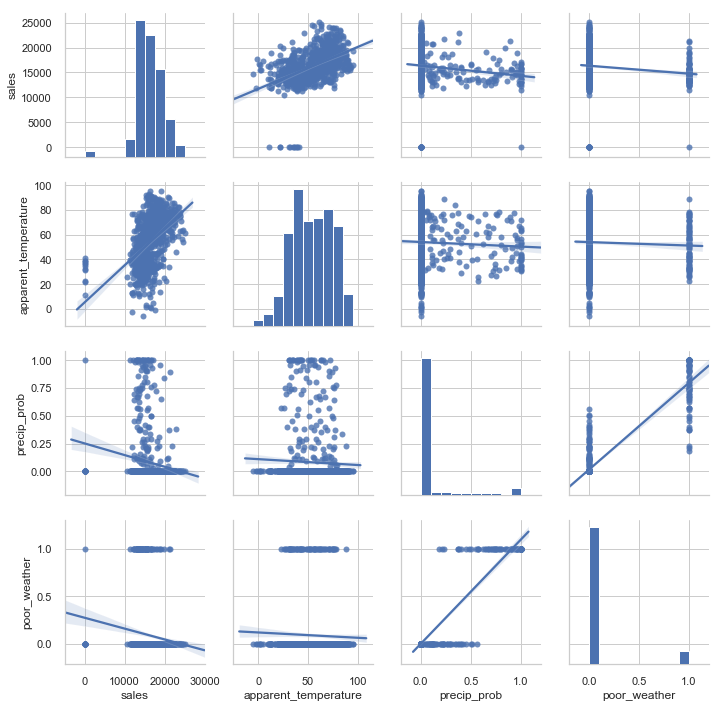

In [2480]:
#Pairplot of Target, Dependent Variables
sns.set(style='whitegrid', palette='deep')
sns.pairplot(dfx, vars=['sales', 'apparent_temperature', 'precip_prob', 'poor_weather'],
                 kind='reg');

## Test / Train / Split

In [2481]:
def prepare_data(df):
    
    # Separate Target & Features
    y = df['sales']
    features = df.drop(['sales'], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[train_date_start:train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[train_date_start:train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    # Scale Data
    #scaler = StandardScaler()
    #X_scaler = scaler.fit(X_train)
    #X_train = pd.DataFrame(data = X_scaler.transform(X_train), columns=features.columns)
    #X_test = pd.DataFrame(data = X_scaler.transform(X_test), columns=features.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = prepare_data(dfx)

Train set:  707
Test set:  145


### Linear Regression

In [2482]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression(fit_intercept=True)
    lr_rgr = lr.fit(X_train, y_train)
    
    return lr_rgr

In [2483]:
lr_rgr = linear_regression_model(X_train, y_train)

In [2484]:
def rgr_score(rgr, X_train, y_train, X_test, y_test):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])
        
rgr_score(lr_rgr, X_train, y_train, X_test, y_test)

Train R-Squared:   0.707068562783453
Test R-Squared:   0.670794206614914 

Intercept:   13489.422751380327 

Coefficients:  

apparent_temperature  -->  58.15597225046981
precip_prob  -->  -1952.0724384370699
closed  -->  -13767.101281206184
poor_weather  -->  -70.05177071131456
sunday_three_day  -->  1236.4451628145891
monday_three_day  -->  -487.63137195038877
dayclus_0  -->  -539.1774014164104
dayclus_1  -->  1886.5893259832285
dayclus_2  -->  -1347.4119245668198
moclus_0  -->  635.9825824274178
moclus_1  -->  -110.65219205003248
moclus_2  -->  -525.3303903773852


## Lasso

In [2464]:
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=0.0001)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

lasso_rgr = lasso_model(X_train, y_train)

In [2465]:
rgr_score(lasso_rgr, X_train, y_train, X_test, y_test)

Train R-Squared:   0.7133871909964968
Test R-Squared:   0.6795857964027371 

Intercept:   12719.426184672844 

Coefficients:  

apparent_temperature  -->  58.431659599139486
precip_prob  -->  -1871.2868189776052
closed  -->  -14009.219737711353
poor_weather  -->  -97.1052194880295
sunday_three_day  -->  1294.0323711580925
monday_three_day  -->  -502.2171454370559
dayclus_0_X_moclus_0  -->  916.9815574781583
dayclus_0_X_moclus_1  -->  -12.383735850789332
dayclus_0_X_moclus_2  -->  -408.834971812618
dayclus_1_X_moclus_0  -->  3527.077258294964
dayclus_1_X_moclus_1  -->  1721.1200532012745
dayclus_1_X_moclus_2  -->  2049.91676687799
dayclus_2_X_moclus_0  -->  -110.36375633936458
dayclus_2_X_moclus_1  -->  -223.4543376678994
dayclus_2_X_moclus_2  -->  -1056.7038823770156


### Lasso Residual Plot

<Figure size 864x576 with 0 Axes>

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1a25133b38>,
       hist=False, line_color=None, model=None, test_color=None,
       train_color=None)

0.6795857964027371

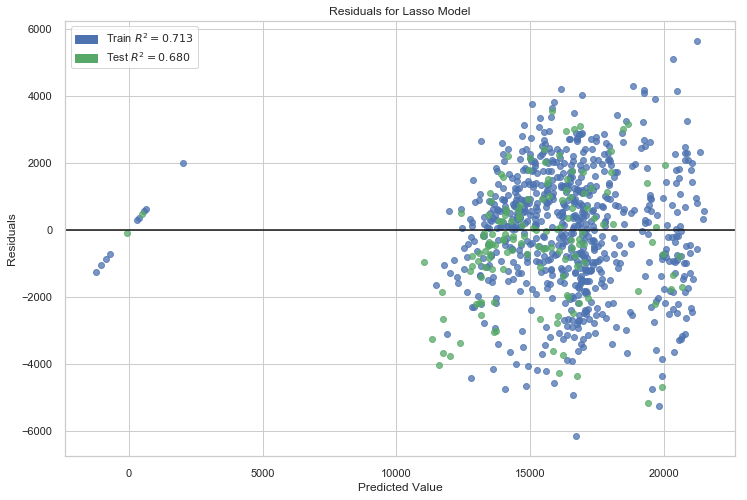

In [2466]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

plt.figure(figsize=(12,8))

visualizer = ResidualsPlot(lasso_rgr, hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()  

### Lasso Regression Prediction

In [2441]:
def predict_df(clf, X_train, date_1, date_2):
    
    lat, long = yelp_lat_long(search_business, location)
    
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    df = add_interactions(add_dummies(add_features(add_clusters((weather_df)))))
    
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns]
    
    pred_array = pd.DataFrame(clf.predict(df), index=df.index, columns=['sales'])
    pred_df = df[df.columns[(df != 0).any()]]
    
    return pd.concat([pred_array, pred_df], axis=1)

predict_df(lasso_rgr, X_train, pd.datetime.now().date(), pd.datetime.now().date() + pd.DateOffset(6))

Coordinates found for Jupiter Disco


,sales,apparent_temperature,precip_prob,poor_weather,dayclus_0_X_moclus_0,dayclus_1_X_moclus_0,dayclus_2_X_moclus_0,dayclus_3_X_moclus_0
date,,,,,,,,
2019-06-11,17101.664463,74.45,0.00,0,0,0,1,0
2019-06-12,17086.792230,68.07,0.00,0,0,0,0,1
2019-06-13,16722.358718,68.12,0.04,0,0,0,1,0
2019-06-14,20339.938853,69.88,0.00,0,1,0,0,0
2019-06-15,20811.473991,79.48,0.00,0,1,0,0,0
2019-06-16,17482.844772,78.23,0.32,1,0,1,0,0
2019-06-17,17570.725354,85.74,0.05,0,0,0,1,0


### Random Forest Regression

In [2442]:
def rf_regression_model(X_train, y_train):
    
    rfr = RandomForestRegressor()
    rfr_rgr = rfr.fit(X_train, y_train)
    
    return rfr_rgr

In [2443]:
rfr_rgr = rf_regression_model(X_train, y_train)

In [2444]:
def rfr_score(rgr, X_test, y_test):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
        
rfr_score(rfr_rgr, X_test, y_test) 

Train R-Squared:   0.9385285830025125
Test R-Squared:   0.5904725854060029 



### Random Forest Regression Prediction

In [2445]:
predict_df(rfr_rgr, X_train, pd.datetime.now().date() - pd.DateOffset(0), pd.datetime.now().date() + pd.DateOffset(6))

Coordinates found for Jupiter Disco


,sales,apparent_temperature,precip_prob,poor_weather,dayclus_0_X_moclus_0,dayclus_1_X_moclus_0,dayclus_2_X_moclus_0,dayclus_3_X_moclus_0
date,,,,,,,,
2019-06-11,16363.4625,74.45,0.00,0,0,0,1,0
2019-06-12,17486.3470,68.07,0.00,0,0,0,0,1
2019-06-13,16554.5180,68.12,0.04,0,0,0,1,0
2019-06-14,16927.9450,69.88,0.00,0,1,0,0,0
2019-06-15,18614.3460,79.48,0.00,0,1,0,0,0
2019-06-16,13885.0390,78.23,0.32,1,0,1,0,0
2019-06-17,18973.6700,85.74,0.05,0,0,0,1,0


### Grid Search Helper Function

In [1565]:
def run_grid_search(rgr, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'r2'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_rgr


In [751]:
params = {
          'n_estimators': [500, 1000],
          'max_depth': [40, 50, 75]
        }

run_grid_search(rfr_rgr, params, X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed:   33.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.5s finished


Grid Search:  RandomForestRegressor 

Grid Search Best Score:  0.6357245028483103
Grid Search Best Params:  {'max_depth': 50, 'n_estimators': 750}
Grid Search Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [748]:
rfr_rgr.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])